In [1]:
!pip install optuna
!pip install optuna-integration
!pip install catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from scipy import stats as st

import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
from optuna.integration import OptunaSearchCV
from optuna.visualization import plot_contour
from catboost import CatBoostRegressor

In [3]:
import sklearn
sklearn.__version__

'1.4.2'

**Описание проекта**
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Инструкция по выполнению проекта**
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Шаг 1. Загрузка данных

In [4]:
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:   
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
taxi.sort_index(inplace=True)
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 6, 3)
print(taxi.head())

                     num_orders  hour  lag_1  lag_2  lag_3  lag_4  lag_5  \
datetime                                                                   
2018-03-01 00:00:00         124     0    NaN    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85     1  124.0    NaN    NaN    NaN    NaN   
2018-03-01 02:00:00          71     2   85.0  124.0    NaN    NaN    NaN   
2018-03-01 03:00:00          66     3   71.0   85.0  124.0    NaN    NaN   
2018-03-01 04:00:00          43     4   66.0   71.0   85.0  124.0    NaN   

                     lag_6  rolling_mean  
datetime                                  
2018-03-01 00:00:00    NaN           NaN  
2018-03-01 01:00:00    NaN           NaN  
2018-03-01 02:00:00    NaN           NaN  
2018-03-01 03:00:00    NaN     93.333333  
2018-03-01 04:00:00    NaN     74.000000  


In [8]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
        # Размер занимаемой памяти до оптимизации (в Мб)
        before_size = df.memory_usage().sum() / 1024**2    
        for column in df.columns:
            column_type = df[column].dtypes
            if column_type in numerics:
                column_min = df[column].min()
                column_max = df[column].max()
                if str(column_type).startswith('int'):
                    if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                        df[column] = df[column].astype(np.int8)
                    elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                        df[column] = df[column].astype(np.int16)
                    elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                        df[column] = df[column].astype(np.int32)
                    elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                        df[column] = df[column].astype(np.int64)  
                else:
                    if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                        df[column] = df[column].astype(np.float32)
                    else:
                        df[column] = df[column].astype(np.float64)    
        # Размер занимаемой памяти после оптимизации (в Мб)
        after_size = df.memory_usage().sum() / 1024**2
        if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                             .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
        return df
optimize_memory_usage(taxi, print_size=True)

Размер использования памяти: до  0.34 Mb - после  0.16 Mb (51.2%)


,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,93.333336
2018-03-01 04:00:00,43,4,66.0,71.0,85.0,124.0,NaN,NaN,74.000000
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,207.0,217.0,197.0,116.0,133.0,166.0,207.000000
2018-08-31 20:00:00,154,20,136.0,207.0,217.0,197.0,116.0,133.0,186.666672
2018-08-31 21:00:00,159,21,154.0,136.0,207.0,217.0,197.0,116.0,165.666672


**Вывод. Проведена загрузка данных. Затем сделано ресемплирование по часу и оптимизорованны данные.**

### Шаг 2. Анализ данных.

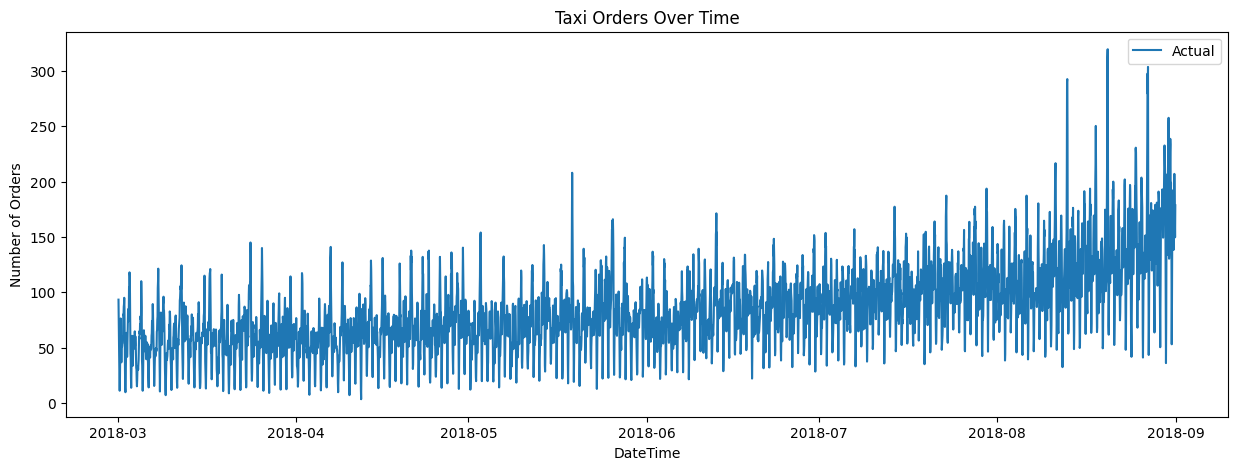

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(taxi['rolling_mean'], label='Actual')
plt.xlabel('DateTime')
plt.ylabel('Number of Orders')
plt.title('Taxi Orders Over Time')
plt.legend()
plt.show()

**Вывод. Существует восходящий тренд. Видны регулярные колебания в данных, что может указывать на наличие сезонных эффектов, также наблюдаются внезапные всплески в количестве заказов.**

### Шаг 3. Обучение моделей.

In [10]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

In [11]:
pipe_final = Pipeline([
    ('model', LinearRegression())
])

param_distributions = {
    'model__fit_intercept': optuna.distributions.CategoricalDistribution([True, False])
}

try:
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
except:
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

optuna_search_lr = OptunaSearchCV(
    pipe_final,
    param_distributions,
    scoring=rmse_scorer,
    n_trials=15,
    n_jobs=-1)

optuna_search_lr.fit(X_train, y_train)

y_pred_1 = optuna_search_lr.predict(X_test)

print('Лучшая модель и её параметры:\n\n', optuna_search_lr.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', optuna_search_lr.best_score_)

C:\Users\vanya\AppData\Local\Temp\ipykernel_23172\909761209.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_lr = OptunaSearchCV(
[I 2024-06-02 23:40:36,845] A new study created in memory with name: no-name-3580fcea-7ee1-4506-83e9-37fb10ecf0ac
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

Лучшая модель и её параметры:

 Pipeline(steps=[('model', LinearRegression())])
Метрика лучшей модели на тренировочной выборке: -31.860857009887695


In [12]:
pipe_final = Pipeline([
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_distributions = {
    'model__max_depth': optuna.distributions.IntDistribution(1, 10),
    'model__min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'model__min_samples_leaf': optuna.distributions.IntDistribution(1, 10),
    'model__max_features': optuna.distributions.FloatDistribution(0.1, 1.0),
}


optuna_search_dt = OptunaSearchCV(
    pipe_final,
    param_distributions,
    scoring=rmse_scorer,
    n_trials=30,
    n_jobs=-1)

optuna_search_dt.fit(X_train, y_train)

y_pred_2 = optuna_search_dt.predict(X_test)


print('Лучшая модель и её параметры:\n\n', optuna_search_dt.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', optuna_search_dt.best_score_)

C:\Users\vanya\AppData\Local\Temp\ipykernel_23172\3405833280.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_dt = OptunaSearchCV(
[I 2024-06-02 23:40:37,306] A new study created in memory with name: no-name-906b247e-ee1b-4045-ab5a-bfa4d15af972
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning

Лучшая модель и её параметры:

 Pipeline(steps=[('model',
                 DecisionTreeRegressor(max_depth=7,
                                       max_features=0.8516740710067926,
                                       min_samples_leaf=2, min_samples_split=8,
                                       random_state=42))])
Метрика лучшей модели на тренировочной выборке: -28.97266807594462


In [13]:

pipe_final_catboost = Pipeline([
    ('models', CatBoostRegressor(
        random_state=RANDOM_STATE,
        verbose=3,
        # task_type='GPU'  
    ))
])

param_distributions_catboost = {
    'models__iterations': optuna.distributions.IntDistribution(10, 40),
    'models__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'models__depth': optuna.distributions.IntDistribution(3, 10),
    'models__l2_leaf_reg': optuna.distributions.IntDistribution(1, 10),
}

optuna_search_catboost = OptunaSearchCV(
    pipe_final_catboost,
    param_distributions_catboost,
    scoring=rmse_scorer,
    n_trials=15,
    n_jobs=-1
)

optuna_search_catboost.fit(X_train, y_train)
y_pred_catboost = optuna_search_catboost.predict(X_test)

print('Лучшая модель и её параметры:\n\n', optuna_search_catboost.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', optuna_search_catboost.best_score_)

C:\Users\vanya\AppData\Local\Temp\ipykernel_23172\3973062270.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_catboost = OptunaSearchCV(
[I 2024-06-02 23:40:38,343] A new study created in memory with name: no-name-2ca5817f-0c99-4b30-b153-8ebabd482cd8


0:	learn: 36.3276037	total: 45.3ms	remaining: 408ms
0:	learn: 35.6414231	total: 71.2ms	remaining: 2.13s
0:	learn: 36.3188627	total: 69.9ms	remaining: 2.17s
0:	learn: 37.7315291	total: 46.3ms	remaining: 1.16s
0:	learn: 37.0929362	total: 45.6ms	remaining: 1.46s
3:	learn: 31.3117265	total: 49.5ms	remaining: 74.2ms
3:	learn: 31.2938899	total: 74.4ms	remaining: 521ms
0:	learn: 36.0409384	total: 6.72ms	remaining: 114ms
0:	learn: 37.8626676	total: 156ms	remaining: 3.12s
3:	learn: 33.2629438	total: 53.3ms	remaining: 386ms
0:	learn: 35.8274535	total: 82.8ms	remaining: 2.65s
0:	learn: 38.3771966	total: 2.57ms	remaining: 25.7ms
6:	learn: 29.1029707	total: 77.9ms	remaining: 278ms
6:	learn: 29.1366803	total: 52.9ms	remaining: 22.7ms
0:	learn: 37.6733685	total: 128ms	remaining: 1.79s
3:	learn: 35.0891013	total: 57.3ms	remaining: 315ms
9:	learn: 28.3954606	total: 56.3ms	remaining: 0us
9:	learn: 28.2149811	total: 81.7ms	remaining: 180ms
0:	learn: 38.6330897	total: 87.7ms	remaining: 2.37s
3:	learn: 29.

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3:	learn: 37.6048938	total: 286ms	remaining: 1.5s
12:	learn: 25.6870961	total: 71.3ms	remaining: 27.4ms
6:	learn: 33.0083031	total: 239ms	remaining: 477ms
6:	learn: 26.8689257	total: 166ms	remaining: 618ms
30:	learn: 25.8586701	total: 105ms	remaining: 6.79ms
3:	learn: 35.3968012	total: 206ms	remaining: 567ms
24:	learn: 27.2425162	total: 110ms	remaining: 4.41ms
18:	learn: 24.6247282	total: 140ms	remaining: 88.4ms
25:	learn: 26.9836445	total: 113ms	remaining: 0us
15:	learn: 25.1466007	total: 89.5ms	remaining: 11.2ms
32:	learn: 25.8230031	total: 109ms	remaining: 0us
9:	learn: 24.9873419	total: 200ms	remaining: 460ms
9:	learn: 31.2124507	total: 272ms	remaining: 300ms
6:	learn: 25.8157128	total: 292ms	remaining: 1.38s
0:	learn: 36.6295323	total: 1.05ms	remaining: 9.5ms
6:	learn: 36.6868896	total: 400ms	remaining: 1.03s
lag_2, bin=174 score 1227.663204
lag_2, bin=88 score 497.8965939
hour, bin=19 score 1307.780742
lag_2, bin=158 score 1010.067512
6:	learn: 33.3243448	total: 313ms	remaining: 

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

9:	learn: 35.8467902	total: 521ms	remaining: 782ms
15:	learn: 28.7676584	total: 340ms	remaining: 106ms
15:	learn: 23.2308233	total: 270ms	remaining: 287ms
0:	learn: 38.9179800	total: 2.23ms	remaining: 22.3ms
6:	learn: 29.1602156	total: 9.02ms	remaining: 3.86ms
0:	learn: 38.1501040	total: 3ms	remaining: 41.9ms
27:	learn: 23.7025346	total: 165ms	remaining: 17.7ms
9:	learn: 28.1937603	total: 12.4ms	remaining: 0us
12:	learn: 23.4663361	total: 508ms	remaining: 1.05s
9:	learn: 31.5751628	total: 428ms	remaining: 214ms
3:	learn: 35.3262189	total: 7.73ms	remaining: 21.3ms
3:	learn: 37.5826489	total: 8.95ms	remaining: 15.7ms
30:	learn: 23.3935836	total: 174ms	remaining: 0us
6:	learn: 32.8255269	total: 12ms	remaining: 13.7ms
6:	learn: 36.3301057	total: 19.2ms	remaining: 11ms
18:	learn: 22.5774342	total: 306ms	remaining: 226ms
18:	learn: 27.9368431	total: 375ms	remaining: 39.5ms
hour, bin=0 score 317.8774261
15:	learn: 23.0275604	total: 591ms	remaining: 887ms
12:	learn: 35.0757384	total: 645ms	rem

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

3:	learn: 38.3071998	total: 6.18ms	remaining: 37.1ms
20:	learn: 27.3966899	total: 398ms	remaining: 0us
3:	learn: 32.2998440	total: 12.8ms	remaining: 25.6ms
12:	learn: 30.1320785	total: 560ms	remaining: 86.1ms
21:	learn: 22.0954305	total: 337ms	remaining: 169ms
6:	learn: 37.5703989	total: 9.22ms	remaining: 27.7ms
15:	learn: 34.3036170	total: 749ms	remaining: 421ms
18:	learn: 22.4603616	total: 696ms	remaining: 769ms
lag_6, bin=29 score 1178.563675


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

0:	learn: 38.2303523	total: 1.3ms	remaining: 32.4ms
6:	learn: 29.6160481	total: 20.8ms	remaining: 14.9ms
9:	learn: 36.8947642	total: 13.4ms	remaining: 24.2ms
14:	learn: 29.3829814	total: 641ms	remaining: 0us
9:	learn: 27.8210793	total: 28.4ms	remaining: 5.68ms
0:	learn: 37.5295086	total: 2.25ms	remaining: 71.9ms
3:	learn: 35.3878196	total: 10ms	remaining: 55.3ms
24:	learn: 21.5011303	total: 363ms	remaining: 116ms
12:	learn: 36.2519604	total: 16.6ms	remaining: 19.1ms
3:	learn: 33.4521332	total: 7.26ms	remaining: 52.6ms
15:	learn: 35.6939000	total: 20.3ms	remaining: 15.3ms
11:	learn: 27.0544090	total: 33.5ms	remaining: 0us
6:	learn: 33.0195847	total: 16.2ms	remaining: 44ms
0:	learn: 36.6199446	total: 1.04ms	remaining: 32.3ms
0:	learn: 36.3702699	total: 5ms	remaining: 85ms
18:	learn: 33.5923933	total: 854ms	remaining: 270ms
21:	learn: 22.2604840	total: 808ms	remaining: 661ms
18:	learn: 35.1852353	total: 24.6ms	remaining: 11.7ms
6:	learn: 30.9971509	total: 18.6ms	remaining: 69.2ms
0:	learn

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


24:	learn: 32.4452367	total: 1.05s	remaining: 0us
3:	learn: 35.3074338	total: 5.33ms	remaining: 14.6ms
3:	learn: 37.7316950	total: 8.79ms	remaining: 15.4ms
9:	learn: 26.4209438	total: 41.8ms	remaining: 33.5ms
32:	learn: 20.5894041	total: 434ms	remaining: 0us
18:	learn: 28.4557876	total: 40.2ms	remaining: 14.8ms
3:	learn: 30.0434114	total: 10.6ms	remaining: 71.4ms
27:	learn: 21.5554592	total: 1000ms	remaining: 428ms
3:	learn: 35.5174997	total: 42.8ms	remaining: 182ms
15:	learn: 26.9662784	total: 18.4ms	remaining: 18.4ms
18:	learn: 26.9896735	total: 37.4ms	remaining: 27.6ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0:	learn: 38.3456948	total: 34.7ms	remaining: 486ms
6:	learn: 27.4844740	total: 18.8ms	remaining: 64.5ms
6:	learn: 36.3793042	total: 14.8ms	remaining: 8.46ms
6:	learn: 32.9602957	total: 10.6ms	remaining: 12.1ms
12:	learn: 25.8394174	total: 51.8ms	remaining: 19.9ms
30:	learn: 21.1874238	total: 1.06s	remaining: 309ms
21:	learn: 27.8460273	total: 46.3ms	remaining: 8.42ms
18:	learn: 26.8040563	total: 22.8ms	remaining: 15.6ms
6:	learn: 33.3227468	total: 64.9ms	remaining: 130ms
21:	learn: 26.7176498	total: 43.2ms	remaining: 21.6ms
9:	learn: 31.2768048	total: 15.3ms	remaining: 7.64ms
0:	learn: 37.1985206	total: 3.18ms	remaining: 35ms
9:	learn: 31.4571204	total: 87.2ms	remaining: 95.9ms
12:	learn: 30.0537774	total: 21.1ms	remaining: 3.25ms
10:	learn: 34.7739387	total: 25.2ms	remaining: 0us
24:	learn: 26.5062261	total: 33.4ms	remaining: 9.36ms
12:	learn: 25.5764348	total: 37.8ms	remaining: 52.3ms
3:	learn: 32.0807598	total: 12.9ms	remaining: 25.9ms
27:	learn: 26.1179731	total: 53ms	remaining: 9

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6:	learn: 28.9395389	total: 25.1ms	remaining: 10.8ms
0:	learn: 39.3923522	total: 739us	remaining: 20ms
6:	learn: 33.7032009	total: 230ms	remaining: 263ms
15:	learn: 29.0379264	total: 139ms	remaining: 43.3ms
36:	learn: 20.7850529	total: 1.23s	remaining: 100ms
32:	learn: 25.8060318	total: 60.3ms	remaining: 0us
9:	learn: 27.1516700	total: 28.2ms	remaining: 0us
30:	learn: 25.9750559	total: 40.5ms	remaining: 1.31ms
18:	learn: 25.0411797	total: 54.7ms	remaining: 34.6ms
9:	learn: 27.2888029	total: 30.4ms	remaining: 6.09ms
31:	learn: 25.9620130	total: 41.8ms	remaining: 0us
11:	learn: 26.5623321	total: 37.3ms	remaining: 0us
3:	learn: 38.5699420	total: 6.03ms	remaining: 36.2ms
18:	learn: 28.2190201	total: 171ms	remaining: 18ms
0:	learn: 36.2296265	total: 15ms	remaining: 480ms
hour, bin=4 score 1652.594837
0:	learn: 39.0500741	total: 38.8ms	remaining: 931ms
21:	learn: 24.4729119	total: 63.2ms	remaining: 25.9ms
6:	learn: 37.8000801	total: 9.86ms	remaining: 29.6ms
39:	learn: 20.5175720	total: 1.34s

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

0:	learn: 38.3846584	total: 3.18ms	remaining: 79.6ms
3:	learn: 38.0413900	total: 140ms	remaining: 738ms
9:	learn: 37.1143009	total: 12.7ms	remaining: 22.9ms
3:	learn: 35.3667452	total: 9.16ms	remaining: 50.4ms
6:	learn: 27.0625833	total: 71.1ms	remaining: 264ms
6:	learn: 33.0568446	total: 15.3ms	remaining: 41.4ms
9:	learn: 31.1522642	total: 24.4ms	remaining: 39.1ms
9:	learn: 25.3548905	total: 99.7ms	remaining: 229ms
0:	learn: 38.6280968	total: 1.71ms	remaining: 24ms
0:	learn: 39.1880031	total: 2.51ms	remaining: 25.1ms
12:	learn: 36.4591763	total: 17.1ms	remaining: 19.8ms
12:	learn: 30.5861015	total: 429ms	remaining: 66ms
12:	learn: 29.7858965	total: 32.2ms	remaining: 32.2ms
0:	learn: 36.4131948	total: 4.91ms	remaining: 83.5ms
27:	learn: 24.1135286	total: 80.7ms	remaining: 8.65ms
14:	learn: 29.8079619	total: 489ms	remaining: 0us
6:	learn: 37.1640284	total: 235ms	remaining: 604ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


12:	learn: 24.3328221	total: 117ms	remaining: 181ms
3:	learn: 35.4175187	total: 7.57ms	remaining: 20.8ms
15:	learn: 28.8136384	total: 39.2ms	remaining: 24.5ms
3:	learn: 30.5186016	total: 16.1ms	remaining: 56.2ms
3:	learn: 37.6787838	total: 9.18ms	remaining: 16.1ms
30:	learn: 23.8796939	total: 88.8ms	remaining: 0us
15:	learn: 35.8532025	total: 21ms	remaining: 15.7ms
Object info sizes: 793 8
9:	learn: 36.3318727	total: 316ms	remaining: 474ms
6:	learn: 36.3514756	total: 14.2ms	remaining: 8.13ms
6:	learn: 27.5118797	total: 25.6ms	remaining: 40.2ms
6:	learn: 32.8918912	total: 12.2ms	remaining: 13.9ms
0:	learn: 37.6580187	total: 1.57ms	remaining: 50.2ms
18:	learn: 35.3250676	total: 24.4ms	remaining: 11.5ms
15:	learn: 23.7529629	total: 137ms	remaining: 146ms
18:	learn: 28.0370299	total: 44.8ms	remaining: 16.5ms
0:	learn: 31.0610571	total: 1.16ms	remaining: 10.4ms
0:	learn: 36.9068585	total: 1.35ms	remaining: 42ms
3:	learn: 33.8075130	total: 6.08ms	remaining: 44.1ms
9:	learn: 31.3022949	total:

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

12:	learn: 25.3282163	total: 55.4ms	remaining: 21.3ms
0:	learn: 38.5251956	total: 5.58ms	remaining: 112ms
0:	learn: 37.2653712	total: 1.8ms	remaining: 19.8ms
21:	learn: 22.7764198	total: 182ms	remaining: 90.9ms
15:	learn: 27.1725330	total: 24.9ms	remaining: 26.4ms
15:	learn: 26.3312476	total: 19.8ms	remaining: 19.8ms
15:	learn: 34.7340702	total: 488ms	remaining: 275ms
0:	learn: 35.9263370	total: 3.12ms	remaining: 93.7ms
0:	learn: 38.5087386	total: 34.2ms	remaining: 479ms
3:	learn: 35.6562893	total: 36.5ms	remaining: 155ms
3:	learn: 32.5254943	total: 17.5ms	remaining: 35.1ms
15:	learn: 25.0649974	total: 68.1ms	remaining: 8.51ms
24:	learn: 22.2708538	total: 211ms	remaining: 67.7ms
0:	learn: 35.1759167	total: 27.1ms	remaining: 1.06s
18:	learn: 26.2536884	total: 23.2ms	remaining: 15.8ms
3:	learn: 29.3870951	total: 11.5ms	remaining: 77.4ms
18:	learn: 26.6982870	total: 29.8ms	remaining: 21.9ms
18:	learn: 34.0174679	total: 596ms	remaining: 188ms
17:	learn: 24.9354714	total: 78.7ms	remaining: 

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

21:	learn: 26.0452427	total: 26.9ms	remaining: 12.2ms
6:	learn: 33.2606867	total: 73ms	remaining: 146ms
6:	learn: 29.3783935	total: 33.8ms	remaining: 24.1ms
27:	learn: 21.9061943	total: 244ms	remaining: 43.5ms
lag_4, bin=176 score 226.275973
3:	learn: 35.8197004	total: 155ms	remaining: 426ms
6:	learn: 27.2337505	total: 34.1ms	remaining: 117ms
21:	learn: 26.3242651	total: 34.7ms	remaining: 17.3ms
24:	learn: 25.9132982	total: 30.7ms	remaining: 8.6ms
24:	learn: 26.0477684	total: 39.6ms	remaining: 12.7ms
27:	learn: 25.7699697	total: 34.3ms	remaining: 4.89ms
9:	learn: 27.5149491	total: 46.8ms	remaining: 9.37ms
9:	learn: 25.6500631	total: 46.8ms	remaining: 98.3ms
11:	learn: 26.6849459	total: 54.1ms	remaining: 0us
27:	learn: 25.8776668	total: 49.4ms	remaining: 8.81ms
3:	learn: 28.8477149	total: 154ms	remaining: 1.39s
9:	learn: 31.4371547	total: 105ms	remaining: 115ms
30:	learn: 21.6048405	total: 278ms	remaining: 17.9ms
rolling_mean, bin=21 score 1177.546576
12:	learn: 25.1016544	total: 54.6ms

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


15:	learn: 28.7578663	total: 152ms	remaining: 47.5ms
0:	learn: 33.0421570	total: 1.07ms	remaining: 15ms
0:	learn: 39.4036404	total: 14.2ms	remaining: 383ms
0:	learn: 33.7517105	total: 2.86ms	remaining: 28.6ms
24:	learn: 32.7686785	total: 835ms	remaining: 0us
3:	learn: 30.5238676	total: 5.62ms	remaining: 15.5ms
9:	learn: 31.8056551	total: 370ms	remaining: 185ms
18:	learn: 24.7447649	total: 71.1ms	remaining: 44.9ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be remove

3:	learn: 32.4657812	total: 9.06ms	remaining: 15.9ms
3:	learn: 38.6052499	total: 18ms	remaining: 108ms
0:	learn: 38.5774440	total: 1.72ms	remaining: 43ms
9:	learn: 24.5922240	total: 376ms	remaining: 1.13s
18:	learn: 27.8072596	total: 176ms	remaining: 18.5ms
6:	learn: 28.6491107	total: 16.1ms	remaining: 18.4ms
21:	learn: 24.3803281	total: 80.8ms	remaining: 33ms
6:	learn: 37.8831395	total: 21.9ms	remaining: 65.7ms
6:	learn: 31.3144063	total: 14.9ms	remaining: 8.53ms
9:	learn: 27.2379602	total: 20.2ms	remaining: 10.1ms
3:	learn: 35.5444614	total: 8.03ms	remaining: 44.2ms
0:	learn: 32.1351369	total: 4.08ms	remaining: 44.9ms
9:	learn: 37.1911764	total: 26ms	remaining: 46.8ms
12:	learn: 26.3482811	total: 24.1ms	remaining: 3.71ms
24:	learn: 23.9659903	total: 89.3ms	remaining: 21.4ms
20:	learn: 27.2610307	total: 192ms	remaining: 0us
6:	learn: 32.9319376	total: 13.5ms	remaining: 36.7ms
12:	learn: 36.5120425	total: 29ms	remaining: 33.5ms
9:	learn: 30.2778739	total: 21.7ms	remaining: 2.17ms
12:	l

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:43,142] Trial 2 finished with value: -30.31661249550816 and parameters: {'models__iterations': 15, 'models__learning_rate': 0.08907995237532335, '

3:	learn: 31.0000539	total: 4.86ms	remaining: 34ms
9:	learn: 24.2194500	total: 25.7ms	remaining: 5.15ms
12:	learn: 29.7373680	total: 23.5ms	remaining: 23.5ms
18:	learn: 35.3859225	total: 36.3ms	remaining: 17.2ms
15:	learn: 23.7662840	total: 511ms	remaining: 766ms
30:	learn: 23.4040499	total: 102ms	remaining: 0us
6:	learn: 27.1697928	total: 23.7ms	remaining: 37.3ms
6:	learn: 28.9036106	total: 8.39ms	remaining: 30ms
11:	learn: 23.6857961	total: 29.8ms	remaining: 0us
15:	learn: 28.7413018	total: 29.1ms	remaining: 18.2ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:43,334] Trial 9 finished with value: -35.47024761288429 and parameters: {'models__iterations': 11, 'models__learning_rate': 0.03284446689314326, 'models__depth': 5, 'models__l2_leaf_reg': 2}. Best is trial 4 with value: -28.93363198506708.
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calcu

0:	learn: 36.2568629	total: 8.57ms	remaining: 274ms
21:	learn: 34.8560487	total: 40.3ms	remaining: 11ms
0:	learn: 39.2434500	total: 28.2ms	remaining: 678ms
0:	learn: 38.1355136	total: 1.76ms	remaining: 56.5ms
18:	learn: 23.3401114	total: 593ms	remaining: 655ms
9:	learn: 25.9279976	total: 33.6ms	remaining: 26.9ms
0:	learn: 38.5802565	total: 12.6ms	remaining: 252ms
9:	learn: 27.3644306	total: 11.8ms	remaining: 26.1ms
24:	learn: 34.3281554	total: 44ms	remaining: 5.27ms
3:	learn: 34.0424047	total: 6.17ms	remaining: 44.7ms
18:	learn: 27.9529408	total: 35.5ms	remaining: 13.1ms
12:	learn: 27.0285119	total: 15.7ms	remaining: 23ms
27:	learn: 33.9371259	total: 47.9ms	remaining: 0us
6:	learn: 31.1521289	total: 11.3ms	remaining: 41.9ms
12:	learn: 25.1325839	total: 45.6ms	remaining: 17.5ms
3:	learn: 29.9369129	total: 37.3ms	remaining: 271ms
15:	learn: 26.8130653	total: 19.3ms	remaining: 19.3ms
9:	learn: 29.2074143	total: 16.9ms	remaining: 38.9ms
18:	learn: 26.5482145	total: 23.9ms	remaining: 16.3ms

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3:	learn: 35.8543971	total: 152ms	remaining: 418ms
12:	learn: 29.9368300	total: 150ms	remaining: 92ms
0:	learn: 36.6532673	total: 1.62ms	remaining: 48.6ms
9:	learn: 36.3598162	total: 335ms	remaining: 503ms
15:	learn: 23.3015125	total: 152ms	remaining: 162ms
0:	learn: 33.9524005	total: 1.42ms	remaining: 38.3ms
3:	learn: 29.8112823	total: 12.1ms	remaining: 81.7ms
3:	learn: 33.3375404	total: 6.11ms	remaining: 36.7ms
15:	learn: 28.7072093	total: 176ms	remaining: 55ms
hour, bin=15 score 73.36345075
18:	learn: 22.8584365	total: 178ms	remaining: 131ms
6:	learn: 32.6405362	total: 11.5ms	remaining: 34.5ms
hour, bin=16 score 214.3660441




lag_1, bin=62 score 446.7570709
rolling_mean, bin=243 score 104.6766678
lag_6, bin=51 score 284.6122509
0:	learn: 33.0978932	total: 2.56ms	remaining: 64.1ms
6:	learn: 26.9489623	total: 21.3ms	remaining: 73.1ms
hour, bin=3 score 998.6211843

6:	learn: 33.6294617	total: 249ms	remaining: 285ms
rolling_mean, bin=141 score 1433.442599
hour, bin=0 score 233.1289214

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


18:	learn: 24.6100948	total: 53.8ms	remaining: 19.8ms
24:	learn: 21.9359588	total: 260ms	remaining: 83.3ms
0:	learn: 31.0534592	total: 1.65ms	remaining: 51.1ms
0:	learn: 31.5351200	total: 12.1ms	remaining: 206ms
21:	learn: 23.9277428	total: 95.2ms	remaining: 38.9ms
3:	learn: 26.9641452	total: 9.59ms	remaining: 67.1ms
30:	learn: 21.8536939	total: 1.05s	remaining: 304ms
15:	learn: 34.6737638	total: 585ms	remaining: 329ms
21:	learn: 24.2208210	total: 78.2ms	remaining: 14.2ms
9:	learn: 31.7513887	total: 417ms	remaining: 208ms
6:	learn: 25.2234259	total: 13ms	remaining: 46.5ms
27:	learn: 21.5513198	total: 301ms	remaining: 53.7ms
3:	learn: 26.2422269	total: 24.5ms	remaining: 85.9ms
0:	learn: 32.4634980	total: 3.88ms	remaining: 124ms
24:	learn: 23.7185588	total: 103ms	remaining: 24.6ms
9:	learn: 24.0791766	total: 17.1ms	remaining: 37.7ms
24:	learn: 23.7736919	total: 85ms	remaining: 3.4ms
3:	learn: 29.1357154	total: 9.65ms	remaining: 70ms
25:	learn: 23.6607604	total: 87.4ms	remaining: 0us
12:	

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:44,270] Trial 3 finished with value: -34.751294880072514 and parameters: {'models__iterations': 28, 'models__learning_rate': 0.02152885768758322, 'models__depth': 3, 'models__l2_leaf_reg': 5}. Best is trial 11 with value: -28.287767238201788.


6:	learn: 26.9935699	total: 17.9ms	remaining: 66.3ms
15:	learn: 23.1786961	total: 25.8ms	remaining: 25.8ms
18:	learn: 22.9544155	total: 28.4ms	remaining: 19.4ms
30:	learn: 23.1675045	total: 120ms	remaining: 0us
9:	learn: 25.4577821	total: 23.4ms	remaining: 53.9ms
12:	learn: 22.1283735	total: 69.9ms	remaining: 26.9ms
36:	learn: 21.1570411	total: 1.26s	remaining: 102ms
31:	learn: 21.9796528	total: 44ms	remaining: 0us
18:	learn: 23.6321259	total: 38.9ms	remaining: 28.7ms
14:	learn: 29.3789602	total: 604ms	remaining: 0us


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:44,573] Trial 8 finished with value: -28.268325287972267 and parameters: {'models__iterations': 26, 'models__learning_rate': 0.07946743884537409, 'models__depth': 5, 'models__l2_leaf_reg': 4}. Best is trial 8 with value: -28.268325287972267.


21:	learn: 33.1477003	total: 815ms	remaining: 111ms
15:	learn: 21.7240432	total: 77.9ms	remaining: 9.73ms
21:	learn: 23.3446739	total: 42.9ms	remaining: 21.4ms
17:	learn: 21.4852897	total: 84.2ms	remaining: 0us
0:	learn: 33.2692327	total: 10.4ms	remaining: 208ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:44,758] Trial 12 finished with value: -26.752599446604354 and parameters: {'models__iterations': 32, 'models__learning_rate': 0.2657918704427059, 

39:	learn: 20.7921790	total: 1.35s	remaining: 0us
24:	learn: 23.0812382	total: 46.3ms	remaining: 14.8ms
Object info sizes: 794 8
lag_2, bin=122 score 1218.860495
Object info sizes: 3175 8
24:	learn: 32.5284444	total: 898ms	remaining: 0us
3:	learn: 30.9809184	total: 26.3ms	remaining: 112ms
27:	learn: 22.7590228	total: 49ms	remaining: 8.75ms
30:	learn: 22.6094684	total: 51.4ms	remaining: 3.32ms
32:	learn: 22.4441038	total: 53.4ms	remaining: 0us
6:	learn: 29.0215538	total: 39.7ms	remaining: 79.4ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:45,169] Trial 10 finished with value: -26.72515256475732 and parameters: {'models__iterations': 18, 'models__learning_rate': 0.19590853177076256, 'models__depth': 7, 'models__l2_leaf_reg': 6}. Best is trial 10 with value: -26.72515256475732.


9:	learn: 27.4454561	total: 53.8ms	remaining: 59.2ms
12:	learn: 26.2966168	total: 67.7ms	remaining: 41.6ms
15:	learn: 25.3043117	total: 81.7ms	remaining: 25.5ms
0:	learn: 36.4317663	total: 6.07ms	remaining: 194ms
0:	learn: 31.0730716	total: 1.92ms	remaining: 57.6ms
3:	learn: 25.8433266	total: 10.4ms	remaining: 70.2ms
6:	learn: 23.9244724	total: 16.8ms	remaining: 57.6ms
9:	learn: 22.8621954	total: 24.9ms	remaining: 52.4ms
18:	learn: 24.4906815	total: 108ms	remaining: 11.4ms
3:	learn: 29.9468469	total: 33ms	remaining: 240ms
0:	learn: 33.2985576	total: 30.3ms	remaining: 424ms
12:	learn: 22.3161413	total: 31.1ms	remaining: 43.1ms
15:	learn: 21.8408704	total: 39.4ms	remaining: 37ms
20:	learn: 24.0746315	total: 124ms	remaining: 0us
6:	learn: 26.5132847	total: 54.2ms	remaining: 201ms
rolling_mean, bin=208 score 1339.233715


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:45,263] Trial 5 finished with value: -26.931727806707386 and parameters: {'models__iterations': 33, 'models__learning_rate': 0.13126461821083582, 

18:	learn: 21.6317285	total: 49.4ms	remaining: 31.2ms
21:	learn: 21.3108840	total: 57.2ms	remaining: 23.4ms
24:	learn: 21.1194201	total: 65.3ms	remaining: 15.7ms
9:	learn: 24.7750251	total: 79.9ms	remaining: 184ms
27:	learn: 20.7527836	total: 70.7ms	remaining: 7.58ms
30:	learn: 20.4009337	total: 75.5ms	remaining: 0us
3:	learn: 31.0057815	total: 111ms	remaining: 307ms
12:	learn: 23.7360468	total: 94.7ms	remaining: 146ms
15:	learn: 23.0518718	total: 109ms	remaining: 116ms
0:	learn: 35.1874994	total: 33.7ms	remaining: 1.31s
18:	learn: 22.4444715	total: 145ms	remaining: 107ms
0:	learn: 39.2616493	total: 38.8ms	remaining: 932ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:45,579] Trial 0 finished with value: -29.146713700710098 and parameters: {'models__iterations': 21, 'models__learning_rate': 0.059829026614911504, 'models__depth': 9, 'models__l2_leaf_reg': 3}. Best is trial 10 with value: -26.72515256475732.
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:45,601] Trial 7 finished with value: -25.630912102844565 and parameters: {'models__iterations': 31, 'models__learning_rate': 0.22842077072534442, 'models__depth'

6:	learn: 29.1497612	total: 199ms	remaining: 227ms
21:	learn: 21.9245161	total: 177ms	remaining: 88.6ms
Object info sizes: 793 8
lag_5, bin=27 score 906.8225233

Object info sizes: 793 8
Object info sizes: 3175 8
hour, bin=0 score 1095.247684
hour, bin=7 score 1217.660604
lag_6, bin=43 score 1352.39767
9:	learn: 24.2424195	total: 354ms	remaining: 1.06s
12:	learn: 23.8432535	total: 420ms	remaining: 872ms
12:	learn: 35.4914483	total: 424ms	remaining: 391ms
15:	learn: 34.6967333	total: 505ms	remaining: 284ms
0:	learn: 31.3176187	total: 9.93ms	remaining: 318ms
15:	learn: 23.2927624	total: 505ms	remaining: 757ms
3:	learn: 26.3324498	total: 39ms	remaining: 283ms

lag_1, bin=54 score 372.7699792


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:46,017] Trial 14 finished with value: -31.1308668756652 and parameters: {'models__iterations': 15, 'models__learning_rate': 0.0581473286328721, 'models__depth': 10, 'models__l2_leaf_reg': 4}. Best is trial 7 with value: -25.630912102844565.


hour, bin=7 score 524.5977014
lag_6, bin=96 score 1245.5606
6:	learn: 23.6998081	total: 68.3ms	remaining: 254ms
9:	learn: 22.3011601	total: 95.8ms	remaining: 220ms
18:	learn: 33.9155330	total: 593ms	remaining: 187ms
18:	learn: 22.8869342	total: 597ms	remaining: 660ms
12:	learn: 21.3765885	total: 121ms	remaining: 186ms
15:	learn: 20.7405563	total: 141ms	remaining: 150ms
18:	learn: 20.2750155	total: 164ms	remaining: 121ms
21:	learn: 33.2212490	total: 682ms	remaining: 92.9ms
21:	learn: 22.3678887	total: 684ms	remaining: 559ms
21:	learn: 19.9367481	total: 186ms	remaining: 92.9ms
24:	learn: 19.5503611	total: 210ms	remaining: 67.1ms
27:	learn: 19.1657638	total: 228ms	remaining: 40.7ms
30:	learn: 18.7591399	total: 249ms	remaining: 16.1ms
32:	learn: 18.5520529	total: 266ms	remaining: 0us
24:	learn: 32.6363585	total: 770ms	remaining: 0us
24:	learn: 22.2414955	total: 772ms	remaining: 463ms
27:	learn: 22.0442003	total: 851ms	remaining: 365ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:46,581] Trial 13 finished with value: -25.921729085039964 and parameters: {'models__iterations': 33, 'models__learning_rate': 0.17770635334858098, 'models__depth': 9, 'models__l2_leaf_reg': 1}. Best is trial 7 with value: -25.630912102844565.


30:	learn: 21.5220388	total: 931ms	remaining: 270ms
33:	learn: 21.2845159	total: 986ms	remaining: 174ms
lag_4, bin=127 score 156.2916346
Object info sizes: 793 8
Object info sizes: 793 8
Object info sizes: 3175 8
lag_3, bin=184 score 93.37789646
lag_3, bin=183 score 118.9856754
36:	learn: 20.9903779	total: 1.06s	remaining: 86.3ms
0:	learn: 33.9067610	total: 25.3ms	remaining: 608ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


39:	learn: 20.5310815	total: 1.14s	remaining: 0us
3:	learn: 33.0226008	total: 96ms	remaining: 504ms
rolling_mean, bin=207 score 1140.993293
0:	learn: 35.5411962	total: 24.8ms	remaining: 966ms
9:	learn: 31.4258027	total: 237ms	remaining: 356ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3:	learn: 28.7434291	total: 105ms	remaining: 944ms
12:	learn: 30.7343223	total: 312ms	remaining: 288ms
6:	learn: 25.9338278	total: 193ms	remaining: 909ms
15:	learn: 30.0608789	total: 396ms	remaining: 223ms
18:	learn: 29.4133529	total: 475ms	remaining: 150ms
9:	learn: 24.0858301	total: 275ms	remaining: 824ms
21:	learn: 28.8759740	total: 550ms	remaining: 75ms
12:	learn: 23.3371072	total: 354ms	remaining: 735ms
24:	learn: 28.3579297	total: 621ms	remaining: 0us
15:	learn: 22.8791318	total: 434ms	remaining: 651ms
18:	learn: 22.6124180	total: 513ms	remaining: 567ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:47,480] Trial 1 finished with value: -33.857294101502674 and parameters: {'models__iterations': 25, 'models__learning_rate': 0.021455411261702365, 'models__depth': 10, 'models__l2_leaf_reg': 7}. Best is trial 7 with value: -25.630912102844565.


21:	learn: 22.0486140	total: 592ms	remaining: 485ms
Object info sizes: 793 8
Object info sizes: 793 8
Object info sizes: 3175 8
0:	learn: 30.5494483	total: 24.6ms	remaining: 959ms
3:	learn: 25.1845360	total: 98.5ms	remaining: 887ms


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6:	learn: 22.7091379	total: 170ms	remaining: 802ms
9:	learn: 21.5234993	total: 243ms	remaining: 730ms
12:	learn: 20.7980795	total: 318ms	remaining: 661ms
15:	learn: 20.1034716	total: 390ms	remaining: 585ms
18:	learn: 19.6639841	total: 462ms	remaining: 511ms
21:	learn: 19.2198245	total: 535ms	remaining: 438ms
24:	learn: 18.9093888	total: 608ms	remaining: 365ms
27:	learn: 18.5809825	total: 682ms	remaining: 292ms
30:	learn: 18.3048187	total: 753ms	remaining: 219ms
33:	learn: 17.9106045	total: 826ms	remaining: 146ms
36:	learn: 17.5914083	total: 898ms	remaining: 72.8ms
39:	learn: 17.2409057	total: 974ms	remaining: 0us


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-02 23:40:49,221] Trial 6 finished with value: -25.850113842224165 and parameters: {'models__iterations': 40, 'models__learning_rate': 0.24547510827452212, 'models__depth': 10, 'models__l2_leaf_reg': 5}. Best is trial 7 with value: -25.630912102844565.


Object info sizes: 793 8
Object info sizes: 3968 8
0:	learn: 35.1263257	total: 1.77ms	remaining: 53ms
3:	learn: 28.8385618	total: 6.24ms	remaining: 42.1ms
6:	learn: 26.7667903	total: 10.7ms	remaining: 36.7ms
9:	learn: 25.4328780	total: 15.3ms	remaining: 32.1ms
12:	learn: 25.0300503	total: 19.5ms	remaining: 26.9ms
15:	learn: 24.7173170	total: 23.8ms	remaining: 22.3ms
18:	learn: 24.3908920	total: 28.3ms	remaining: 17.9ms
21:	learn: 23.9150646	total: 32.7ms	remaining: 13.4ms
24:	learn: 23.6580326	total: 37ms	remaining: 8.89ms
27:	learn: 23.5747276	total: 40.5ms	remaining: 4.34ms
30:	learn: 23.5340699	total: 44.8ms	remaining: 0us
Object info sizes: 442 8
Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 <catboost.core.CatBoostRegressor object at 0x000002A84AC4F2E0>)])
Метрика лучшей модели на тренировочной выборке: -25.630912102844565


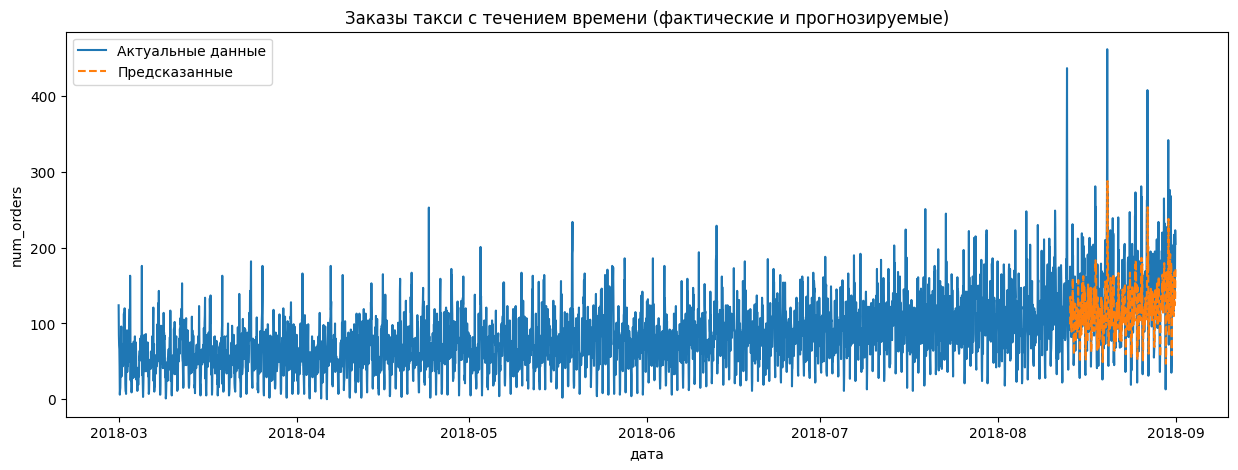

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(taxi.index, taxi['num_orders'], label='Актуальные данные')
plt.plot(taxi.index[-len(y_test):], y_pred_1, label='Предсказанные', linestyle='--')
plt.xlabel('дата')
plt.ylabel('num_orders')
plt.title('Заказы такси с течением времени (фактические и прогнозируемые)')
plt.legend()
plt.show()

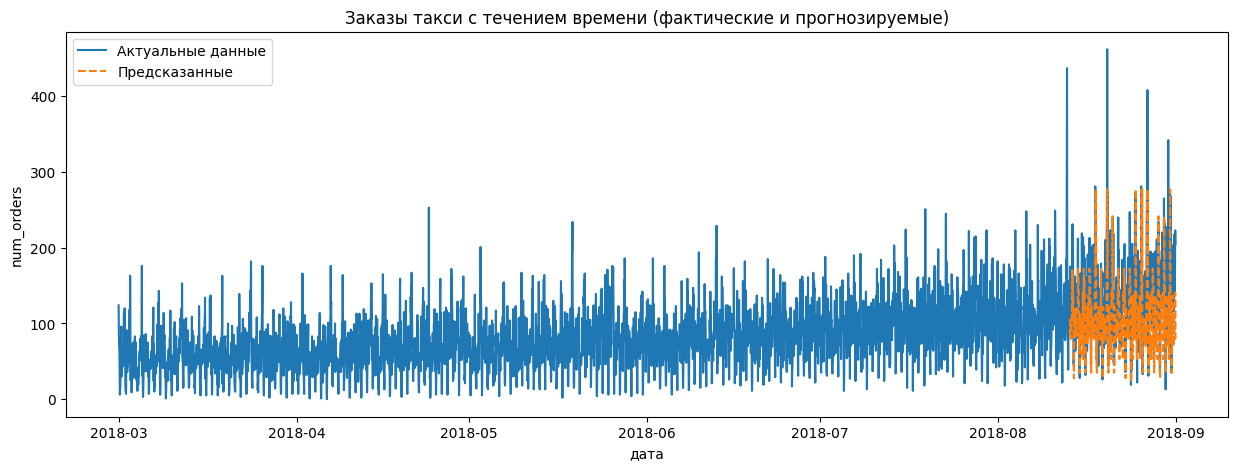

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(taxi.index, taxi['num_orders'], label='Актуальные данные')
plt.plot(taxi.index[-len(y_test):], y_pred_2, label='Предсказанные', linestyle='--')
plt.xlabel('дата')
plt.ylabel('num_orders')
plt.title('Заказы такси с течением времени (фактические и прогнозируемые)')
plt.legend()
plt.show()

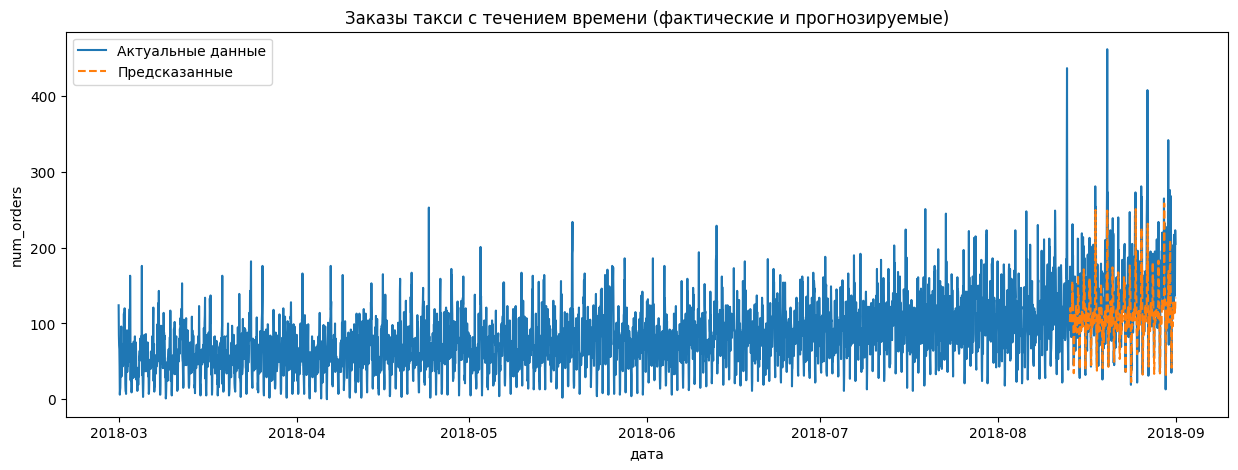

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(taxi.index, taxi['num_orders'], label='Актуальные данные')
plt.plot(taxi.index[-len(y_test):], y_pred_catboost, label='Предсказанные', linestyle='--')
plt.xlabel('дата')
plt.ylabel('num_orders')
plt.title('Заказы такси с течением времени (фактические и прогнозируемые)')
plt.legend()
plt.show()

### Шаг 4. Выводы.

1. **Задача данного проекта была в постройке модели для предсказания числа заказов.**

2. **В ходе анализа данных было произведено ресемплирование по часу, добавлены отстающие значения и скользящее среднее. Так же датасет был оптимизирован(2.02 Mb - после  0.96 Mb (52.5%))**

3. **Все три модели(LinearRegression, DecisionTreeRegressor и CatBoostRegressor) показали примерно одинаковое значение RMSE (около 5.6), однако судя по графикам более точно изменение числа заказов показали LinearRegression и CatBoostRegressor.**

4. **Заказчику рекомендованно использовать LinearRegression, либо CatBoostRegressor для более точного предсказания.**